# Imports

In [1]:
import keras
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
from zipfile import ZipFile

In [2]:
df = pd.read_csv('../housing.csv')
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


# Cleaning

In [3]:
df.isna().mean()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

In [4]:
df.total_bedrooms.fillna(method='pad', inplace=True)
df_drop = df.dropna()

In [5]:
df.isna().mean()

longitude             0.0
latitude              0.0
housing_median_age    0.0
total_rooms           0.0
total_bedrooms        0.0
population            0.0
households            0.0
median_income         0.0
median_house_value    0.0
ocean_proximity       0.0
dtype: float64

# Data viz

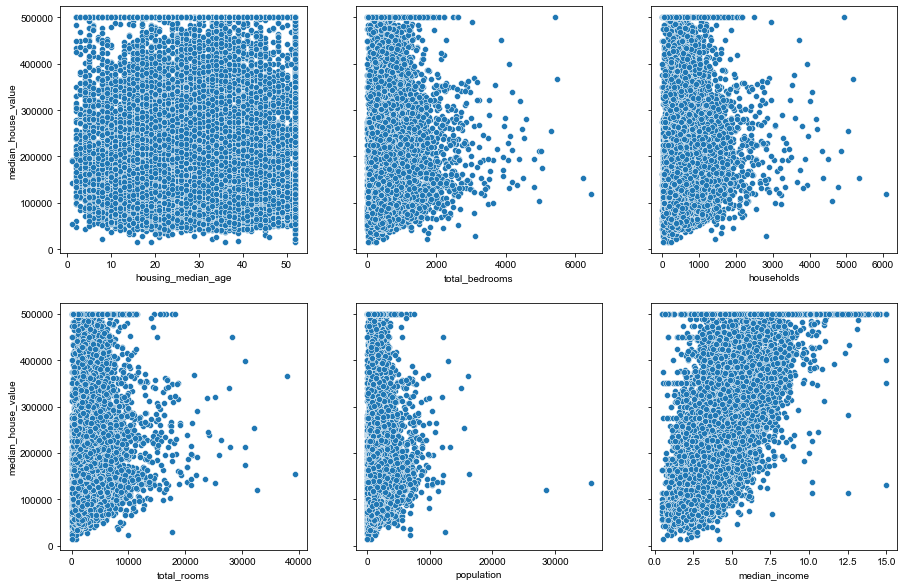

In [6]:
variables = ['housing_median_age', 'total_rooms', 'total_bedrooms', 
             'population', 'households', 'median_income']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
sns.set()

i = 0
j = 0
for var in variables:
    sns.scatterplot(ax = axes[i, j], data = df, x = var, y = 'median_house_value')
    i += 1 
    if i%2 == 0:
        j += 1
        i = 0

Median income seems to have a non linear relation with the median house value.

# Features

In [7]:
df['median_income_sq'] = df['median_income']**2

In [8]:
# One-hot encoding of the ocean proximity

for item in list(df.ocean_proximity.unique()):
    df[item] = (df.ocean_proximity == item)

df = df.drop('ocean_proximity', axis=1)

In [9]:
data = df

# Model

## Hyperparameters gridsearch

In [10]:
import keras
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

x = data.drop('median_house_value', axis=1).astype('float32')
y = data.median_house_value

#x[float_conv] = x[float_conv].astype('float32')
x = np.asarray(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [11]:
# Define R2 loss function

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [12]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout

def build_model(neurons = [256, 128, 64],
               activation_fct = 'relu',
               dropout_rate = 0.2,
               optimizer = tf.keras.optimizers.RMSprop()):
    
    inputs = Input(shape = (x_train.shape[1],))
    
    norm = BatchNormalization(axis = -1,
        momentum = 0.99,
        epsilon = 0.001,
        center = True,
        scale = True,
        beta_initializer = "zeros",
        gamma_initializer = "ones",
        moving_mean_initializer = "zeros",
        moving_variance_initializer = "ones")
    
    x = norm(inputs)
    x = Dense(neurons[0], activation = activation_fct)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons[1], activation = activation_fct)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons[2], activation = activation_fct)(x)
    outputs = Dense(1)(x)
    
    model = keras.Model(inputs = inputs, outputs = outputs, name = "Housing")

    model.compile(
        loss=tf.keras.losses.MeanAbsolutePercentageError(reduction="auto", name="mean_absolute_percentage_error"),
        optimizer=optimizer,
        metrics=[coeff_determination, 'mse'],
    )
    
    return model


In [13]:
perf = []
i = 0
neuron_rank = 0
gridsearch = {'neurons': [[256, 128, 64], [128, 64, 32], [64, 32, 16]],
            'acts': ['relu', 'tanh', 'sigmoid'],
            'drops': [0.1, 0.2, 0.3],
            'opts': [tf.keras.optimizers.RMSprop(), tf.keras.optimizers.Adam()]}

for neuron in gridsearch['neurons']:
    for act in gridsearch['acts']:
        for drop in gridsearch['drops']:
            for opt in gridsearch['opts']:
                
                model = build_model(neuron, act, drop, opt)
                model.fit(x_train, y_train, batch_size=256, epochs=20, validation_split=0.4, verbose=0)
                
                test_scores = model.evaluate(x_test, y_test, verbose=0)
                
                params = [neuron, act, drop, opt, test_scores[0], test_scores[1]]
                
                perf.append(params)

                i+=1
    neuron_rank+=1

scores = []
for model in perf:
    scores.append(model[-2]) # We get the score back
best_model = np.array(scores).argmin()

print('#############')
print('The best model has parameters :')
print('Neurons :', perf[best_model][0])
print('Activation function :', perf[best_model][1])
print('Dropout rate :', perf[best_model][2])
print('Optimizer :', perf[best_model][3])
print('For loss :', perf[best_model][4])

#############
The best model has parameters :
Neurons : [256, 128, 64]
Activation function : relu
Dropout rate : 0.3
Optimizer : <keras.optimizer_v2.adam.Adam object at 0x0000024E15A6DF40>
For loss : 23.770994186401367


## Model_fillna

In [14]:
import keras
import numpy as np
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.model_selection import train_test_split

x = data.drop('median_house_value', axis=1).astype('float32')
y = data.median_house_value

#x[float_conv] = x[float_conv].astype('float32')
x = np.asarray(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [15]:
data.drop('median_house_value', axis=1).columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_income_sq', 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN',
       'ISLAND'],
      dtype='object')

In [16]:
inputs = Input(shape = (x_train.shape[1],))

norm = BatchNormalization(axis = -1,
    momentum = 0.99,
    epsilon = 0.001,
    center = True,
    scale = True,
    beta_initializer = "zeros",
    gamma_initializer = "ones",
    moving_mean_initializer = "zeros",
    moving_variance_initializer = "ones")

x = norm(inputs)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(8, activation = 'relu')(x)
outputs = Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="housing")
model.summary()

Model: "housing"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 14)]              0         
                                                                 
 batch_normalization_54 (Bat  (None, 14)               56        
 chNormalization)                                                
                                                                 
 dense_216 (Dense)           (None, 32)                480       
                                                                 
 dropout_108 (Dropout)       (None, 32)                0         
                                                                 
 dense_217 (Dense)           (None, 16)                528       
                                                                 
 dropout_109 (Dropout)       (None, 16)                0         
                                                           

In [17]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(reduction="auto", name="mean_absolute_percentage_error"),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[coeff_determination]
)

history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.4, verbose=0)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

129/129 - 0s - loss: 24.8448 - coeff_determination: 0.4347 - 292ms/epoch - 2ms/step
Test loss: 24.844778060913086
Test accuracy: 0.4347052276134491


In [31]:
filepath = r'..\model\nn_model'

model.save(filepath)

INFO:tensorflow:Assets written to: ..\model\nn_model\assets


In [26]:
import joblib
filename = r'..\model\nn_model.sav'
joblib.dump(model, filename)

INFO:tensorflow:Assets written to: ram://2ac77505-b3c3-4792-88d0-ca81943ed51a/assets


NotFoundError: 

In [ ]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['coeff_determination'])
plt.plot(history.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('coeff_determination')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(r'../graphs/training_nn_loss.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(r'../graphs/training_nn_r2.png')
plt.show()